<a href="https://colab.research.google.com/github/aashu-0/llm-from-scratch/blob/main/llm_book_notes/07instruct-fine-tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Mar 29 16:16:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**Instruction fine tuning**
- also called supervised instruction fine tuning
- tuning llm to follow instructions


#### 1. Preparing the dataset

##### Download the Stanford Alpaca dataset from github

In [2]:
import json
import urllib.request

url = "https://raw.githubusercontent.com/tatsu-lab/stanford_alpaca/refs/heads/main/alpaca_data.json"

file_path = 'alpaca_data.json'
urllib.request.urlretrieve(url, file_path)

# load
with open(file_path, 'r', encoding='utf-8') as f:
    dataset = json.load(f)

print(f'Number of entries: {len(dataset)}')

Number of entries: 52002


In [3]:
# a subset of the dataset -> 10k samples

import random
subset_size = 5000
random.seed(42)
subset_data = random.sample(dataset, subset_size) # a list of dictionaries

# save
subset_file_path = 'alpaca_subset.json'

# to convert list to json-formatted string
with open(subset_file_path, 'w', encoding='utf-8') as f:
    json.dump(subset_data, f, indent=4)

print(f'Number of entries: {len(subset_data)}')

Number of entries: 5000


In [4]:
# subset_data[:18]

In [5]:
# load the subset_data

with open(subset_file_path, 'r', encoding='utf-8') as f:
    subset_dataset = json.load(f)

print(f'Number of entries: {len(subset_dataset)}')

Number of entries: 5000


In [6]:
print(f'Example:\n {subset_dataset[4000]}') # no input section

Example:
 {'instruction': 'Edit this sentence to use proper English: I dont think so', 'input': '', 'output': "I don't think so."}


In [7]:
print(f'Example:\n {subset_dataset[1000]}')

Example:
 {'instruction': "Explain why the Earth's temperature fluctuates.", 'input': '', 'output': "The Earth's temperature fluctuates due to changes in the amount of energy from the Sun that is received, released or reflected by the atmosphere and surface of the Earth. Changes in clouds, aerosols, oceans, and land also affect temperature. Additionally, increases in certain gasses, such as carbon dioxide, traps heat within the atmosphere and causes further warming."}


so the structure of the dataset looks like:


```
{'instruction":
  'input':  #may be empty
  'output':}
```
there are various ways to format these entries:
- `Alpaca prompt style`
- `Phi-3 prompt style`


##### Implementing the formatting function

In [8]:
def format_input(entry):
  instruction_txt = (
      f"Below is an instruction that describes a task. "
      f"Write a response that appropriately completes the request.\n\n"
      f"### Instruction:\n{entry['instruction']}"
  )
  input_text = (
      f"\n\n### Input:\n{entry['input']}" if entry['input'] else ''
  )
  return instruction_txt + input_text


In [9]:
model_input = format_input(subset_dataset[1000])
desired_response = f"\n\n### Response:\n{subset_dataset[1000]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Explain why the Earth's temperature fluctuates.

### Response:
The Earth's temperature fluctuates due to changes in the amount of energy from the Sun that is received, released or reflected by the atmosphere and surface of the Earth. Changes in clouds, aerosols, oceans, and land also affect temperature. Additionally, increases in certain gasses, such as carbon dioxide, traps heat within the atmosphere and causes further warming.


##### Train Test Split

In [10]:
train_set = int(len(subset_dataset)*0.85)
test_set = int(len(subset_dataset)*0.1)
val_set = len(subset_dataset) - train_set - test_set

train_data = subset_dataset[:train_set]
test_data = subset_dataset[train_set:train_set+test_set]
val_data = subset_dataset[train_set+test_set:]

print(f'Train set size: {len(train_data)}')
print(f'Test set size: {len(test_data)}')
print(f'Validation set size: {len(val_data)}')

Train set size: 4250
Test set size: 500
Validation set size: 250


#### 2. Organizing data into batches

`collate` function in pytorch
- used to batch samples together into a single batch
- allows custom preprocessing, when dealing with variable-length data

1. `default_collate`
- stackes tensor along the first dim
- convert lists into tensors
- leaves dic and other data structures untouched
2. `collate_fn`
- for creating custom collate function

**Custom Collate function**

1. format data
2. tokenize
3. adjust them to have same length using padding tokens
4. create target token ids ---inputs shifted by `1`
5. replace certain pad tokens
  * why? --- do not contain useful info so excluded from loss computation
  * `ignore_index`: placeholder value(`-100`)



##### Instruction dataset class

In [11]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
  def __init__(self, data, tokenizer):
    self.data = data
    self.encode_texts = []
    for entry in data:
      input_with_instruction = format_input(entry)
      response_text = f"\n\n### Response:\n{entry['output']}"
      full_text = input_with_instruction + response_text
      self.encode_texts.append(
          tokenizer.encode(full_text)
      )

  def __getitem__(self, index):
     return self.encode_texts[index]

  def __len__(self):
    return len(self.data)

##### Custom Batch collate function

In [12]:
def custom_collate_fn(
    batch,
    pad_token_id= 50256,
    allowed_max_length=None,
    ignore_index=-100,
    device = 'cpu'):

  batch_max_length = max(len(item) for item in batch)
  inputs_lst, targets_lst = [], []
  for item in batch:
    new_item = item.copy()
    new_item += [pad_token_id]

    padded = (new_item + [pad_token_id]* (batch_max_length - len(item)))
    inputs= torch.tensor(padded[:-1])
    targets= torch.tensor(padded[1:])

    mask = targets == pad_token_id
    indices = torch.nonzero(mask).squeeze() # returns the indices of True values
    if indices.numel() >1:
      targets[indices[1:]] = ignore_index

    if allowed_max_length is not None:
      inputs = inputs[:allowed_max_length]
      targets = targets[:allowed_max_length]

    inputs_lst.append(inputs)
    targets_lst.append(targets)

  inputs_tensor = torch.stack(inputs_lst).to(device)
  targets_tensor = torch.stack(targets_lst).to(device)

  return inputs_tensor, targets_tensor


In [13]:
# example
input1 = [0,1,2,3,4]
input2 = [5,6]
input3 = [7,8,9]

batch = [input1, input2, input3]

input, target = custom_collate_fn(batch)
print(input)
print(target)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


Why `-100`?

by default `ignore_index` in `cross_entropy()` is equal to `-100`.

therefore, it ignores targets labeled with -100

Masking out the instruction text- so that model focuses on generating accurate responses ratehr than memorizing instructions.

will do later

##### Creating dataloaders

In [14]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [15]:
# fix or pre-fill some argument in custom_collate_function
from functools import partial
custom_collate_fn = partial(
    custom_collate_fn,
    allowed_max_length=512,
    device=device
)

In [16]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.1 MB/s eta 0:00:00


In [17]:
# tokenizer
import tiktoken
tokenizer = tiktoken.get_encoding('gpt2')

In [18]:
# dataloader
from torch.utils.data import DataLoader

num_workers = 0
batch_size =2

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=custom_collate_fn,
    num_workers=num_workers,
    drop_last=True,
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate_fn,
    num_workers=num_workers,
    drop_last=False,
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate_fn,
    num_workers=num_workers,
    drop_last=False,
)

In [19]:
for inputs, targets in train_loader:
  print(f'Inputs: {inputs.shape}, Targets: {targets.shape}')
  break

Inputs: torch.Size([2, 104]), Targets: torch.Size([2, 104])


#### Loading Pretrained LLM

In [20]:
# getting scripts from github
!git clone https://github.com/aashu-0/llm-from-scratch.git
%cd llm-from-scratch/llm_book_notes

Cloning into 'llm-from-scratch'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 136 (delta 74), reused 79 (delta 32), pack-reused 0 (from 0)
Receiving objects: 100% (136/136), 183.51 KiB | 15.29 MiB/s, done.
Resolving deltas: 100% (74/74), done.
/content/llm-from-scratch/llm_book_notes


In [21]:
import sys
sys.path.append('/content/llm-from-scratch/llm_book_notes')

In [22]:
# get gpt_download.py from @rasbt github
import urllib.request
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
urllib.request.urlretrieve(url, "gpt_download.py")

('gpt_download.py', <http.client.HTTPMessage at 0x79c16d93b990>)

In [23]:
from load_weights import load_weights_into_gpt
from GPT import GPTModel
from gpt_download import download_and_load_gpt2

BASE_CONFIG = {
    'vocab_size': 50257,
    'context_length': 1024,
    'drop_rate': 0.2,
    'qkv_bias': True
}

model_configs = {
    'gpt2 (124M)': {'emb_dim': 768 , 'n_layers': 12, 'n_heads': 12},
    'gpt2-medium (355M)': {'emb_dim':1024 , 'n_layers':24, 'n_heads':16},
    'gpt2-large (774M)': {'emb_dim': 1280 , 'n_layers': 36, 'n_heads':20},
    'gpt2-xl (1558M)': {'emb_dim': 1600, 'n_layers':48, 'n_heads': 25}
}

CHOOSE_MODEL = 'gpt2-medium (355M)'
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(' ')[-1].lstrip('(').rstrip(')')

settings, params = download_and_load_gpt2(
    model_size = model_size,
    models_dir = 'gpt2'
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 104kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:02<00:00, 515kiB/s]
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 113kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [08:17<00:00, 2.85MiB/s]
model.ckpt.index: 100%|██████████| 10.4k/10.4k [00:00<00:00, 12.4MiB/s]
model.ckpt.meta: 100%|██████████| 927k/927k [00:01<00:00, 581kiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 370kiB/s]


In [24]:
# assess our raw model(no fine tuning)
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Generate a sentence that represents the content in the paragraph.

### Input:
A new law was introduced in 2020 outlining five safety measures all workplaces must follow to prevent the spread of Covid-19. This includes regularly sanitizing the premises, implementing social distancing measures, and introducing a screening and temperature checking procedure.


In [26]:
# model's response
from utilities import text_to_token_ids, token_ids_to_text
from GPT import generate

token_ids = generate(
    model = model,
    idx = text_to_token_ids(input_text, tokenizer),
    max_new_tokens =35,
    context_size= BASE_CONFIG['context_length'],
    eos_id= 50256
)
generated_text =token_ids_to_text(token_ids, tokenizer)
generated_text

'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nGenerate a sentence that represents the content in the paragraph.\n\n### Input:\nA new law was introduced in 2020 outlining five safety measures all workplaces must follow to prevent the spread of Covid-19. This includes regularly sanitizing the premises, implementing social distancing measures, and introducing a screening and temperature checking procedure.\n\n### Output:\n\nThe law was passed and the new law is now in effect.\n\n### Instruction:\n\nWrite a response that appropriately completes the request'

the generate function returns combined input and output text,separating the output

In [27]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Output:

The law was passed and the new law is now in effect.

### Instruction:

Write a response that appropriately completes the request


#### Finetuning LLM on instruction dataset we loaded eariler

In [29]:
from utilities import train_model_simple, calc_loss_loader

In [30]:
# initial loss for the train and val dataset
model.to(device)
torch.manual_seed(123)
with torch.no_grad():
  train_loss = calc_loss_loader(train_loader, model, device)
  val_loss = calc_loss_loader(val_loader, model, device)

print(f'Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}')

Train loss: 3.2672, Val loss: 3.3169


In [32]:
import gc
gc.collect()

torch.cuda.empty_cache()

In [33]:
# training code
import time

start_time = time.time()
torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(),
                              lr=0.00005,
                              weight_decay=0.1)

num_epochs = 2
train_losses, val_losses, tokens_seen = train_model_simple(
    model=model,
    train_dataloader= train_loader,
    val_dataloader= val_loader,
    optimizer= optimizer,
    device=device,
    num_epochs= num_epochs,
    eval_freq= 5,
    eval_iter= 5,
    start_context= format_input(val_data[0]),
    tokenizer= tokenizer
    )

end_time = time.time()

time_in_mins = (end_time - start_time)/60
print(f'Time taken to train: {time_in_mins:.2f} minutes')

Epoch: 1 | Step: 000000
Train Loss: 2.974 | Val Loss: 2.815
Epoch: 1 | Step: 000005
Train Loss: 2.010 | Val Loss: 2.103
Epoch: 1 | Step: 000010
Train Loss: 1.771 | Val Loss: 1.797
Epoch: 1 | Step: 000015
Train Loss: 1.459 | Val Loss: 1.722
Epoch: 1 | Step: 000020
Train Loss: 1.930 | Val Loss: 1.687
Epoch: 1 | Step: 000025
Train Loss: 1.695 | Val Loss: 1.643
Epoch: 1 | Step: 000030
Train Loss: 1.728 | Val Loss: 1.628
Epoch: 1 | Step: 000035
Train Loss: 1.680 | Val Loss: 1.622
Epoch: 1 | Step: 000040
Train Loss: 1.562 | Val Loss: 1.598
Epoch: 1 | Step: 000045
Train Loss: 1.516 | Val Loss: 1.592
Epoch: 1 | Step: 000050
Train Loss: 1.439 | Val Loss: 1.586
Epoch: 1 | Step: 000055
Train Loss: 1.609 | Val Loss: 1.584
Epoch: 1 | Step: 000060
Train Loss: 1.521 | Val Loss: 1.588
Epoch: 1 | Step: 000065
Train Loss: 1.565 | Val Loss: 1.588
Epoch: 1 | Step: 000070
Train Loss: 1.545 | Val Loss: 1.589
Epoch: 1 | Step: 000075
Train Loss: 1.665 | Val Loss: 1.598
Epoch: 1 | Step: 000080
Train Loss: 1.33

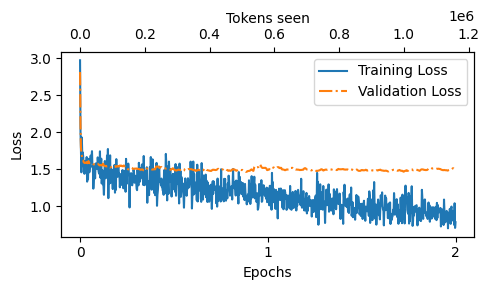

In [35]:
from utilities import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

#### Evaluation

In [41]:
torch.manual_seed(1234)

for entry in test_data[-5:-1]:
  input_text = format_input(entry)
  token_ids= generate(
      model= model,
      idx= text_to_token_ids(input_text, tokenizer).to(device),
      max_new_tokens= 256,
      context_size= BASE_CONFIG['context_length'],
      eos_id= 50256
  )

  generated_text = token_ids_to_text(token_ids, tokenizer)

  response_text = (generated_text[len(input_text):]
                   .replace("### Response:", "")
                   .strip()
  )

  print(input_text)
  print(f"\nCorrect response:\n>> {entry['output']}")
  print(f"\nModel response:\n>> {response_text.strip()}")
  print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Summarize the following article about climate change: 

"Climate change is one of the biggest challenges facing the world today. Recent studies suggest that the global temperature is rising faster than before, with an increase of around one degree Celsius within the last century. Climate change is causing floods, droughts, extreme weather conditions, and other natural disasters. This is putting our environment, ecosystems, and human health and safety at risk.

Correct response:
>> Climate change is causing global temperatures to rise faster than ever and has led to an increase of around 1 degree Celsius in the past century. This is resulting in floods, droughts, and extreme weather events, causing a risk to our environment, ecosystems, and human health and safety.

Model response:
>> Climate change is one of the biggest challenges facing the world today. Recent st

##### Generating test set responses and adding them to a dictionary

In [44]:
# generating test set responses

from tqdm import tqdm
for i, entry in tqdm(enumerate(test_data), total= len(test_data)):
  input_text = format_input(entry)

  token_ids = generate(
      model= model,
      idx= text_to_token_ids(input_text, tokenizer).to(device),
      max_new_tokens= 256,
      context_size= BASE_CONFIG['context_length'],
      eos_id = 50256
  )

  generated_text = token_ids_to_text(token_ids, tokenizer)

  response_text = (generated_text[len(input_text):]
                   .replace("### Response:", "")
                   .strip()
  )
  test_data[i]["model_response"] = response_text

with open('instruction-data-with-response.json', 'w') as file:
  json.dump(test_data, file, indent=4)

100%|██████████| 500/500 [22:56<00:00,  2.75s/it]


In [45]:
# check for a response
print(test_data[6])

{'instruction': 'Generate an example of a job offer letter.', 'input': '', 'output': 'Dear [Candidate Name], \n\nWe are delighted to offer you the position of [Position Name] with [Company Name]. You will be joining our team of dedicated and hardworking individuals who are committed to providing our customers with the highest quality of service. \n\nThis position offers competitive pay of [Salary], and you will receive benefits according to our company policy. We believe you will be an excellent addition to our team and we look forward to you joining us. \n\nPlease let us know if you accept the offer by [date]. If you have any questions, please do not hesitate to contact us. \n\nWe hope to hear from you soon! \n\nSincerely,\n[Company Name]', 'model_response': 'Dear [Employer Name],\n\n\nI am writing to apply for a position at [Company Name] and I am looking for a role that is flexible and rewarding.\n\nI am very motivated and I am ready to learn as much as possible about the position a

In [46]:
import re
file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-medium355M-sft.pth
